# SmartGrid - Analytics - Ggroup 14 - LSTM Model
LSTM Model 

Completed by: 
- Anfaal Mahbub - 30140009 
- Mehvish Shakeel - 30161318



Trains an LSTM model to forecast hourly electricity consumption.

Workflow:
1. Load processed dataset
2. Normalize features
3. Create 24-hour sliding windows
4. Split into train/test (time-series split)
5. Build and train LSTM model
6. Evaluate with MAE and RMSE
7. Save model, predictions, metrics, training curves

### Imports / Dependencies 


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import matplotlib.pyplot as plt
import json
import os
from ucimlrepo import fetch_ucirepo 

## 1. Load Dataset

The dataset is fetched directly from the UCI Machine Learning Repository using the
`ucimlrepo` package. The raw data has:

- Separate `Date` and `Time` columns  
- Missing values encoded as `'?'`  
- Minute-level sampling frequency  
- Multiple power-related features  

We merge the timestamp, convert numeric fields, and prepare the data for modeling.


In [2]:
individual_household_electric_power_consumption = fetch_ucirepo(id=235) 

dataset = individual_household_electric_power_consumption

df = pd.concat([dataset.data.features, dataset.data.targets], axis=1)

df.head()

c:\Users\anfaa\Documents\University Stuff\5th Year - Engg\Fall - 2025\519\Final Project\SmartGrid-Analytics\venv\Lib\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## 2. Preprocessing

This step performs all necessary cleaning so the model trains on valid numerical data.

Operations performed:
- Combine `Date` and `Time` into a single datetime index  
- Convert all values to numeric  
- Drop rows with invalid or missing data  
- Resample to **hourly averages** (reducing noise & making forecasting feasible)  
- Scale all features using MinMaxScaler  
- Create sliding windows (24-hour history → predict 1 hour ahead)  

This preprocessing is identical for both the MLP and LSTM models to ensure a fair comparison.


In [3]:
# Convert Date + Time into a single datetime index
df["datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H:%M:%S",
    errors="coerce"
)

df = df.dropna(subset=["datetime"])
df = df.set_index("datetime")
df = df.drop(columns=["Date", "Time"])

# Convert ALL columns to numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Drop missing values
df = df.dropna()

# Resample to hourly data
df = df.resample("h").mean().dropna()

df.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


### Scale the Features

In [4]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

target_col_index = 0   # Global_active_power


### Create the Sliding Windows

In [5]:
def create_sequences(data, window_size=24):
    """
    Creates sliding-window sequences for supervised time-series forecasting.

    Args:
        data (np.ndarray): Scaled time-series data of shape (num_samples, num_features)
        window_size (int): Number of past time steps to include per sample

    Returns:
        X (np.ndarray): Input sequences shaped (samples, window_size, num_features)
        y (np.ndarray): Target values (next-step prediction)
    """
    
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size, target_col_index])
    return np.array(X), np.array(y)

WINDOW = 24
X, y = create_sequences(scaled_data, WINDOW)

X.shape, y.shape


((34144, 24, 7), (34144,))

## 3. Train/Test Split

For time-series forecasting we **do not shuffle** the data.

We use an 80/20 split:
- First 80% → training  
- Last 20% → testing  

This preserves chronological order and prevents data leakage.


In [6]:
split_idx = int(0.8 * len(X))

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))


Train samples: 27315
Test samples: 6829


## 4. Build LSTM Model (Sequence Model)

The LSTM model learns **temporal dependencies** in electricity consumption.

LSTM can capture:
- Daily usage cycles  
- Evening/morning peaks  
- Short-term fluctuations  

Architecture:
- LSTM(64, return_sequences=True)
- LSTM(32)
- Dense(1) output  


In [7]:
model = keras.Sequential([
    keras.layers.Input(shape=(WINDOW, X.shape[2])),
    keras.layers.LSTM(64, return_sequences=True),       # learn patterns within each 24-hour window
    keras.layers.LSTM(32),                              # compress sequence into meaningful features
    keras.layers.Dense(1)                               # predict next-hour power usage  
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Train the Model

We train using:
- `Adam` optimizer  
- Mean Squared Error (MSE) loss  
- Mean Absolute Error (MAE) metric  
- 20–30 epochs  
- Batch size: 32  

Validation performance is tracked to detect overfitting.


In [8]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/20
854/854 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0111 - mae: 0.0770 - val_loss: 0.0079 - val_mae: 0.0724
Epoch 2/20
854/854 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0085 - mae: 0.0658 - val_loss: 0.0062 - val_mae: 0.0552
Epoch 3/20
854/854 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0081 - mae: 0.0634 - val_loss: 0.0061 - val_mae: 0.0551
Epoch 4/20
854/854 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0079 - mae: 0.0619 - val_loss: 0.0062 - val_mae: 0.0562
Epoch 5/20
854/854 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0078 - mae: 0.0615 - val_loss: 0.0059 - val_mae: 0.0556
Epoch 6/20
854/854 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0077 - mae: 0.0606 - val_loss: 0.0059 - val_mae: 0.0536
Epoch 7/20
854/854 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0076 - mae: 0.0602 - val_loss: 0.0059 - val_mae: 0.0550
Epoch 8/20
854/854 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0075 - mae: 0.0597 - val_loss: 0.0059 - val_mae: 0.0535
Epoch 9/20
854/854 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms

## 6. Evaluate Model

We compute two regression metrics:

- **MAE (Mean Absolute Error):**  
  Average prediction error  

- **RMSE (Root Mean Squared Error):**  
  Penalizes large mistakes more heavily  

These metrics are used to compare MLP vs LSTM accuracy.


In [9]:
preds = model.predict(X_test).ravel()

mse = mean_squared_error(y_test, preds)
rmse = mse ** 0.5
mae = model.evaluate(X_test, y_test, verbose=0)[1]

print("LSTM Metrics:")
print("RMSE:", rmse)
print("MAE:", mae)


214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM Metrics:
RMSE: 0.0744729944398731
MAE: 0.051638759672641754


## 7. Predictions vs Actual (Visualization)

We plot the first 300 predicted vs. true scaled power values.  
This helps visually inspect:
- Trend following  
- Smoothness  
- Major deviations  
- Peaks/trough alignment  


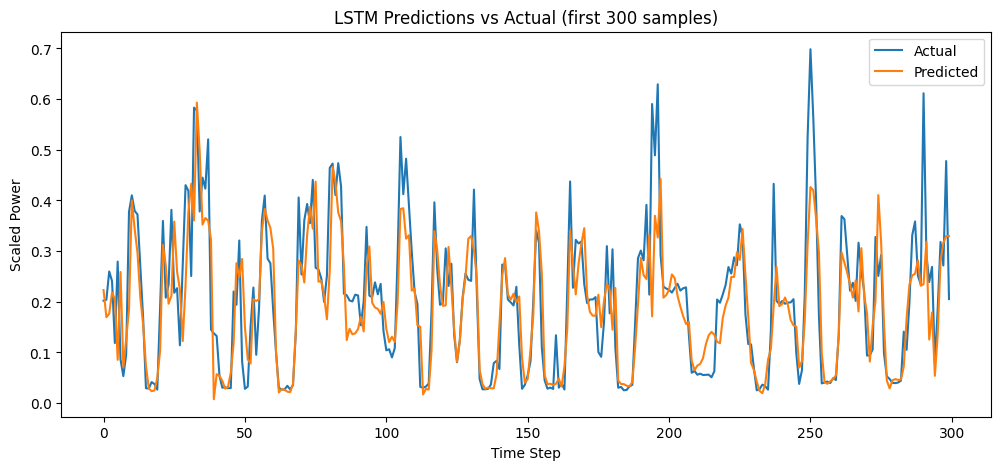

In [10]:
plt.figure(figsize=(12,5))
plt.plot(y_test[:300], label="Actual")
plt.plot(preds[:300], label="Predicted")
plt.title("LSTM Predictions vs Actual (first 300 samples)")
plt.xlabel("Time Step")
plt.ylabel("Scaled Power")
plt.legend()
plt.show()


## 8. Training Curves (Loss + MAE)

Training curves show:
- Whether the model is learning  
- Overfitting (training diverges from validation)  
- Convergence behavior  

These help interpret model performance beyond raw metrics.


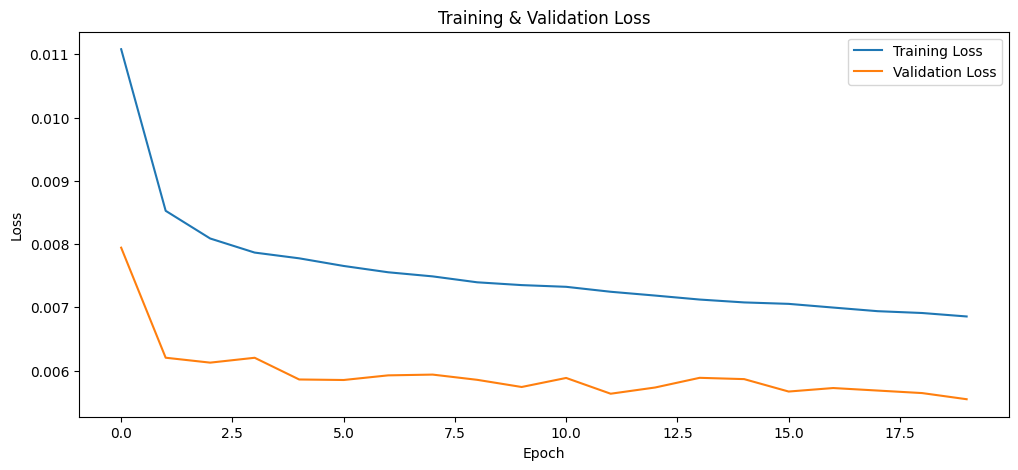

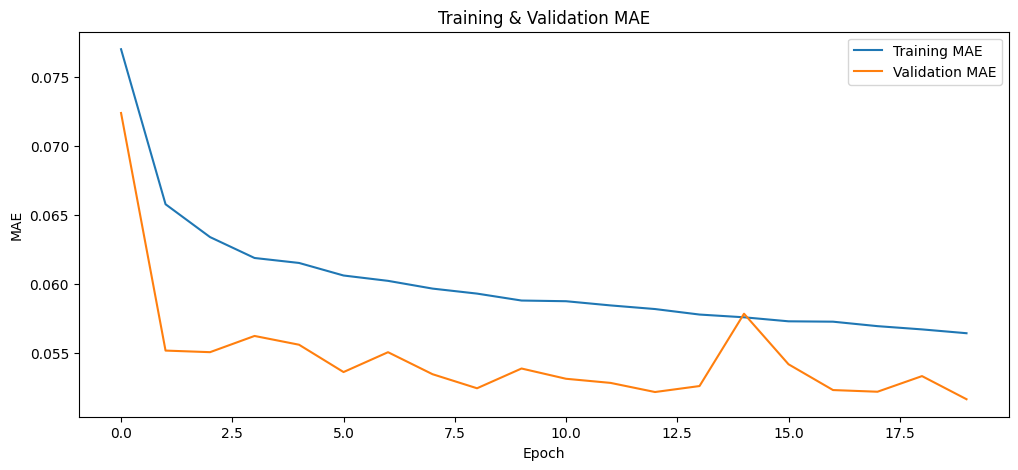

In [11]:
plt.figure(figsize=(12,5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.title("Training & Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()
